In [4]:
import pandas as pd

enso = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/censo.data',
                    delim_whitespace=True,header=None,skiprows=1,skipfooter=2, engine='python')
pdo = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/pdo.data',
                    delim_whitespace=True,header=None,skiprows=1,skipfooter=14, engine='python')
nao = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/nao.data',
                    delim_whitespace=True,header=None,skiprows=1,skipfooter=3, engine='python')
ao = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/ao.data',
                    delim_whitespace=True,header=None,skiprows=1,skipfooter=3, engine='python')
tornado = pd.read_csv('https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv', engine='python')

In [5]:
nao_new=pd.DataFrame()
pdo_new=pd.DataFrame()
ao_new=pd.DataFrame()
enso_new=pd.DataFrame()

enso_new['Date']=pd.date_range(start=pd.datetime(1948,1,1),
                                end=pd.datetime(2022,12,1),freq="MS")
nao_new['Date'] = pd.date_range(start=pd.datetime(1948,1,1),
                                end=pd.datetime(2022,12,1),freq="MS")
pdo_new['Date'] = pd.date_range(start=pd.datetime(1948,1,1),
                                end=pd.datetime(2022,12,1),freq="MS")
ao_new['Date'] = pd.date_range(start=pd.datetime(1950,1,1),
                                end=pd.datetime(2022,12,1),freq="MS")

enso_new = enso_new.set_index('Date')
nao_new = nao_new.set_index('Date')
pdo_new = pdo_new.set_index('Date')
ao_new = ao_new.set_index('Date')

enso_new['ENSO']=enso.loc[:,1:].stack().values
nao_new['NAO']=nao.loc[:,1:].stack().values
pdo_new['PDO']=pdo.loc[:,1:].stack().values
ao_new['AO']=ao.loc[:,1:].stack().values

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future versio

In [6]:
tornado['count']=[1 for i in range(len(tornado))]
tornado1 = tornado[tornado['st'].isin(['IL','IN','WI','MI','MS','IA','MN'])]
tornado1 = tornado1['count'].groupby([tornado.yr,tornado.mo]).sum()

In [24]:
tornado1

yr    mo
1950  1       2
      2       2
      3       8
      4       1
      5       4
           ... 
2021  7      59
      8      78
      9       7
      10     27
      12    107
Name: count, Length: 751, dtype: int64

In [7]:
import numpy as np
newdf_all = pd.merge(enso_new,pdo_new, 
                    left_index=True, right_index=True)
newdf_all['PDO'][newdf_all['PDO'] <= -9.9] = np.nan
newdf_all['ENSO'][newdf_all['ENSO'] <= -9.9] = np.nan
newdf_all = pd.merge(newdf_all,nao_new, 
                    left_index=True, right_index=True)
newdf_all['NAO'][newdf_all['NAO'] <= -99.9] = np.nan
newdf_all = pd.merge(newdf_all,ao_new, 
                    left_index=True, right_index=True)
newdf_all['AO'][newdf_all['AO'] <= -99.9] = np.nan


In [8]:
newdf_all.index = pd.MultiIndex.from_arrays([newdf_all.index.year, 
                                            newdf_all.index.month], 
                                            names=['yr','mo'])

In [9]:
newdf1 = pd.merge(newdf_all,tornado1, 
                    left_index=True, right_index=True)

In [30]:
newdf1

ENSO   PDO   NAO     AO  count
yr   mo                                
1950 1  -0.74 -2.13  0.56 -0.060      2
     2  -1.70 -2.91  0.01  0.627      2
     3  -1.43 -1.13 -0.78 -0.008      8
     4  -1.29 -1.20  0.65  0.555      1
     5  -1.22 -2.23 -0.50  0.072      4
...       ...   ...   ...    ...    ...
2021 7  -1.05 -1.87  0.06  0.625     59
     8  -0.73 -1.12 -0.49 -0.217     78
     9  -0.70 -1.53 -0.06 -0.247      7
     10 -1.04 -2.55 -1.98 -0.139     27
     12 -1.60 -2.00  0.18  0.201    107

[751 rows x 5 columns]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(newdf1.drop(['count'], axis=1),
                                                    newdf1['count'],
                                                    test_size=0.2,
                                                    random_state=0)

In [13]:
# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

tornado_pipe = Pipeline([   
        ('missing_ind', mdi.AddMissingIndicator(
        variables=['ENSO', 'PDO',  'NAO','AO'])),
        ("RF", RandomForestRegressor(500)),
    ]
)

R^2 before one hot encoding on months= 0.08839170554918678
RMSE= 18.64824896135032


Text(0, 0.5, 'predicted output')

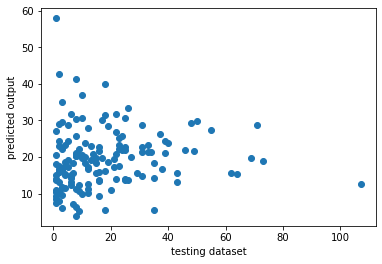

In [15]:

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math
import sklearn.metrics 

tornado_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = tornado_pipe.predict(X_train)
X_test_preds = tornado_pipe.predict(X_test)

print('R^2 before one hot encoding on months=',
        pearsonr(y_test,X_test_preds)[0])
print('RMSE=',
        math.sqrt(sklearn.metrics.mean_squared_error(X_test_preds,y_test)))
plt.scatter(y_test, X_test_preds);
plt.xlabel('testing dataset')
plt.ylabel('predicted output')

In [16]:
from sklearn.preprocessing import OneHotEncoder
newdf2 = newdf1.reset_index(level=[1])
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
onehot_encoded = pd.DataFrame(onehot_encoder.fit_transform(newdf2[['mo']]).toarray(),
                            columns=[str(i) for i in range(12)])
onehot_encoded.index= newdf2.index

In [17]:
onehot_encoded

,0,1,2,3,4,5,6,7,8,9,10,11
yr,,,,,,,,,,,,
1950,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
newdf3 = pd.concat([onehot_encoded,newdf2],axis=1)

In [34]:
for i in range(12):
    newdf3.rename(columns={str(i):'month='+str(i+1)},inplace=True)

R^2 after one hot encoding= 0.3973006089346705
RMSE= 18.304430154318823


Text(0, 0.5, 'predicted output')

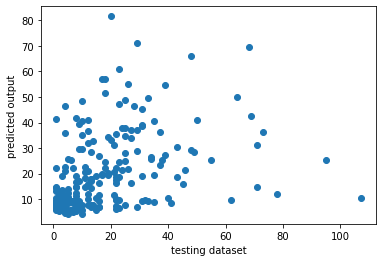

In [36]:

X_train1, X_test1, y_train1, y_test1 = train_test_split(newdf3.drop(['count','mo'],axis=1),
                                                        newdf3['count'],test_size=0.3, 
                                                        random_state=0)
model2 = RandomForestRegressor()
model2.fit(X_train1, y_train1)

# let's get the predictions
X_test_preds1 = model2.predict(X_test1)

print('R^2 after one hot encoding=', 
        pearsonr(y_test1,X_test_preds1)[0])
print('RMSE=',
        math.sqrt(sklearn.metrics.mean_squared_error(X_test_preds1,y_test1)))
plt.scatter(y_test1, X_test_preds1);
plt.xlabel('testing dataset')
plt.ylabel('predicted output')

## R^2 comparison of model without and with feature engineering
As evident from the printed values, model including the one hot encoded months as features along with climate indices performs better with R^2 ~0.38 whereas the model with just climate indices as features performs poor with insignificant R^2 ~ 0.09. This indicates that the temporal occurence of climate indices plays an important role in predicting the number of tornadoes in particular month.

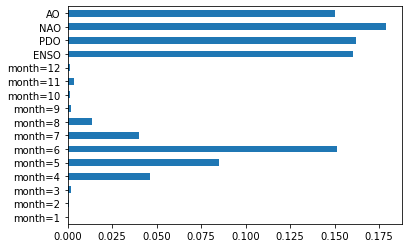

In [37]:
importance = pd.Series(model2.feature_importances_)
importance.index = newdf3.drop(['mo','count'],axis=1).columns
# importance.sort_values(inplace=True, ascending=False)
importance.plot.barh(figsize=(6,4))
plt.show()

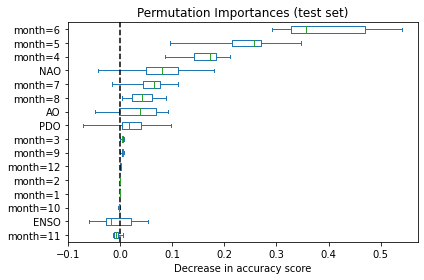

In [38]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model2, X_test1, y_test1, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns= newdf3.drop(['mo','count'],axis=1).columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [40]:
# Fits the explainer
import shap
explainer = shap.Explainer(
                model2.predict, newdf3.drop(['mo','count'],axis=1)
            )
# Calculates the SHAP values - It takes some time
shap_values = explainer( newdf3.drop(['mo','count'],axis=1))

Permutation explainer: 752it [05:17,  2.22it/s]                         


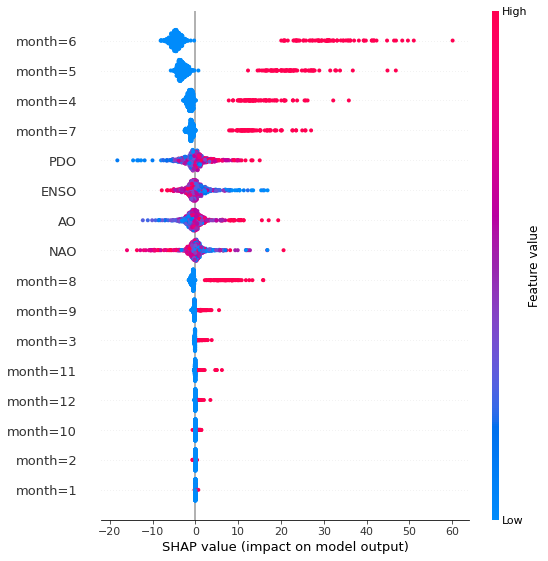

In [41]:
shap.summary_plot(shap_values)

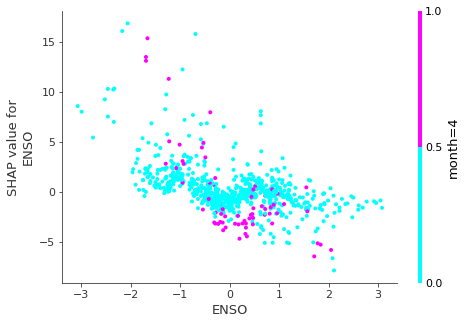

In [47]:
shap.dependence_plot('ENSO',shap_values.values,newdf3.drop(['mo','count'],axis=1),cmap=plt.get_cmap("cool"))

## Interpretation from XAI techniques
From various XAI techniques, in this case feature importance and shap values, NAO is the most important climate index and 6th month is most important feature according to both the techniques.